# 14.1. Image Augmentation

Na Seção 8.1 , mencionamos que grandes conjuntos de dados são um pré-requisito para o sucesso de redes neurais profundas em várias aplicações. O aumento de imagem gera exemplos de treinamento semelhantes, mas distintos, após uma série de alterações aleatórias nas imagens de treinamento, expandindo assim o tamanho do conjunto de treinamento. Alternativamente, o aumento de imagem pode ser motivado pelo fato de que ajustes aleatórios de exemplos de treinamento permitem que os modelos dependam menos de certos atributos, melhorando assim sua capacidade de generalização. Por exemplo, podemos cortar uma imagem de diferentes maneiras para fazer o objeto de interesse aparecer em diferentes posições, reduzindo assim a dependência de um modelo na posição do objeto. Também podemos ajustar fatores como brilho e cor para reduzir a sensibilidade de um modelo à cor. É provavelmente verdade que o aumento de imagem era indispensável para o sucesso do AlexNet naquela época. Nesta seção, discutiremos essa técnica amplamente usada em visão computacional.



# 14.1.1. Métodos comuns de aumento de imagem

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

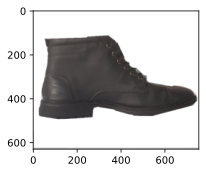

In [6]:
d2l.set_figsize()

# img = d2l.Image.open('../img/cat1.jpg')
# original_image = Image.open(Path('G:\\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\data\\FashionMNIST')
                            # / 'minha_bota2.png')
img = d2l.Image.open('G:\\Meu Drive\\0-DOUTORADO\\0-Python\\PycharmProjects\\data\\FashionMNIST\\minha_bota2.png')
d2l.plt.imshow(img);


__A maioria dos métodos de aumento de imagem tem um certo grau de aleatoriedade.__ Para facilitar a observação do efeito do aumento de imagem, definimos uma função auxiliar apply. Esta função executa o método de aumento de imagem augvárias vezes na imagem de entrada img e mostra todos os resultados.

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

# 14.1.1.1. Inversão e corte

Inverter a imagem para a esquerda e para a direita geralmente não altera a categoria do objeto. Este é um dos métodos mais antigos e amplamente usadosde aumento de imagem. Em seguida, usamos o transformsmódulo para criar a RandomHorizontalFlip instância, que inverte uma imagem para a esquerda e para a direita com 50% de chance.

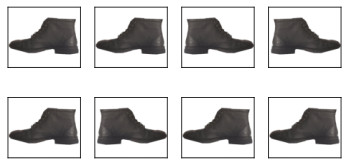

In [8]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

Virar para cima e para baixo não é tão comum quanto virar para a esquerda e para a direita. Mas, pelo menos para esta imagem de exemplo, virar para cima e para baixo não atrapalha o reconhecimento. Em seguida, criamos uma RandomVerticalFlipinstância para virar uma imagem para cima e para baixo com 50% de chance.

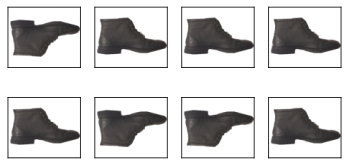

In [12]:
apply(img, torchvision.transforms.RandomVerticalFlip())

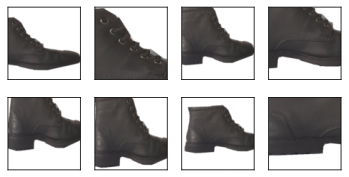

In [14]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

# 14.1.1.2. Alterando cores

Outro método de aumento é mudar as cores. Podemos mudar quatro aspectos da cor da imagem: brilho, contraste, saturação e matiz. No exemplo abaixo, mudamos aleatoriamente o brilho da imagem para um valor entre 50% (1-0.5) e 150% (1+0.5) da imagem original.



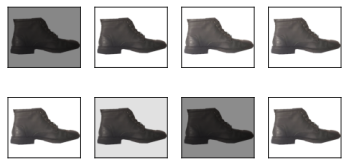

In [17]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

Da mesma forma, podemos alterar aleatoriamente o matiz da imagem.

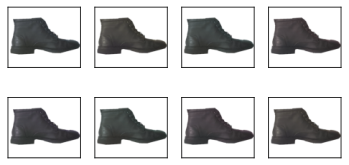

In [36]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))


Também podemos criar uma RandomColorJitter instância e definir como alterar aleatoriamente brightness, contrast, saturation, e hueda imagem ao mesmo tempo.

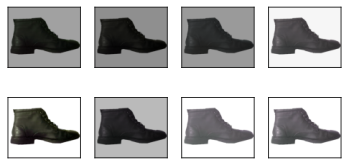

In [37]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

# 14.1.1.3. Combinando vários métodos de aumento de imagem

Na prática, combinaremos vários métodos de aumento de imagem. Por exemplo, podemos combinar os diferentes métodos de aumento de imagem definidos acima e aplicá-los a cada imagem por meio de uma Compos e instância.

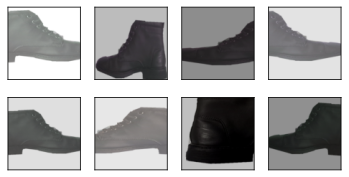

In [38]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), 
    color_aug, 
    shape_aug])
apply(img, augs)

In [ ]:
from torchvision.transforms import v2

trans = transforms.Compose([v2.Resize(size=(28,28)),        # resize para 224x224
                            v2.RandomHorizontalFlip(p=1),   # inverte a imagem 
                            # v2.RandomResizedCrop(size=(50, 50), antialias=True),                        # corta a imagem
                            # v2.ToDtype(torch.float32, scale=True),                                        # muda o tipo 
                            # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.ToTensor()])   

# v2.RandomHorizontalFlip()   # inverte a imagem horizontalmente
# v2.RandomVerticalFlip()     # inverte a imagem verticalmente
# v2.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))  # corta a imagem
# v2.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0)   # altera o brilho, contrast, saturação e/ou matiz(hue)


# 14.1.2. Treinamento com Aumento de Imagem

Vamos treinar um modelo com aumento de imagem. Aqui usamos o conjunto de dados CIFAR-10 em vez do conjunto de dados Fashion-MNIST que usamos antes. Isso ocorre porque a posição e o tamanho dos objetos no conjunto de dados Fashion-MNIST foram normalizados, enquanto a cor e o tamanho dos objetos no conjunto de dados CIFAR-10 têm diferenças mais significativas. As primeiras 32 imagens de treinamento no conjunto de dados CIFAR-10 são mostradas abaixo.

100%|███████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:10<00:00, 16901173.78it/s]


Extracting ../data\cifar-10-python.tar.gz to ../data


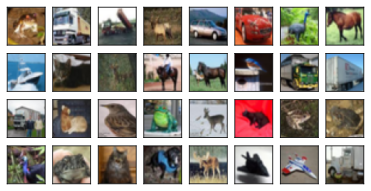

In [39]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

Para obter resultados definitivos durante a predição, geralmente aplicamos aumento de imagem apenas a exemplos de treinamento e não usamos aumento de imagem com operações aleatórias durante a predição. Aqui, usamos apenas o método de inversão aleatória esquerda-direita mais simples. Além disso, usamos uma ToTensorinstância para converter um minibatch de imagens no formato exigido pela estrutura de aprendizado profundo, ou seja, números de ponto flutuante de 32 bits entre 0 e 1 com o formato de (tamanho do lote, número de canais, altura, largura).

In [40]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

Em seguida, definimos uma função auxiliar para facilitar a leitura da imagem e aplicar o aumento da imagem. O transformargumento fornecido pelo conjunto de dados do PyTorch aplica o aumento para transformar as imagens. Para uma introdução detalhada a DataLoader, consulte a Seção 4.2 .

In [41]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

# 14.1.2.1. Treinamento com aumento de dados

Agora podemos definir a train_with_data_augfunção para treinar o modelo com aumento de imagem. Esta função obtém todas as GPUs disponíveis, usa Adam como o algoritmo de otimização, aplica aumento de imagem ao conjunto de dados de treinamento e, finalmente, chama a train_ch13função recém-definida para treinar e avaliar o modelo.

In [44]:
#14.1.2.1. Treinamento Multi-GPU
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [45]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Vamos treinar o modelo usando aumento de imagem com base na inversão aleatória da esquerda para a direita.

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

-------------------------

# Código Agrupado

In [ ]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);


train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])
# Para obter resultados definitivos durante a previsão, normalmente aplicamos o aumento de imagem apenas a exemplos de treinamento e
# não usamos o aumento de imagem com operações aleatórias durante a previsão.


def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader



#-------------------------------------------

# #14.1.2.1. Treinamento Multi-GPU
# def train_batch_ch13(net, X, y, loss, trainer, devices):
#     """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
#     if isinstance(X, list):
#         # Required for BERT fine-tuning (to be covered later)
#         X = [x.to(devices[0]) for x in X]
#     else:
#         X = X.to(devices[0])
#     y = y.to(devices[0])
#     net.train()
#     trainer.zero_grad()
#     pred = net(X)
#     l = loss(pred, y)
#     l.sum().backward()
#     trainer.step()
#     train_loss_sum = l.sum()
#     train_acc_sum = d2l.accuracy(pred, y)
#     return train_loss_sum, train_acc_sum
#
# #@save
# def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
#                devices=d2l.try_all_gpus()):
#     """Train a model with multiple GPUs (defined in Chapter 13)."""
#     timer, num_batches = d2l.Timer(), len(train_iter)
#     animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
#                             legend=['train loss', 'train acc', 'test acc'])
#     net = nn.DataParallel(net, device_ids=devices).to(devices[0])
#     for epoch in range(num_epochs):
#         # Sum of training loss, sum of training accuracy, no. of examples,
#         # no. of predictions
#         metric = d2l.Accumulator(4)
#         for i, (features, labels) in enumerate(train_iter):
#             timer.start()
#             l, acc = train_batch_ch13(
#                 net, features, labels, loss, trainer, devices)
#             metric.add(l, acc, labels.shape[0], labels.numel())
#             timer.stop()
#             if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
#                 animator.add(epoch + (i + 1) / num_batches,
#                              (metric[0] / metric[2], metric[1] / metric[3],
#                               None))
#         test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
#         animator.add(epoch + 1, (None, None, test_acc))
#     print(f'loss {metric[0] / metric[2]:.3f}, train acc '
#           f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
#     print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
#           f'{str(devices)}')

#-------------------------------------------


batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

#-------------------------------------------

train_with_data_aug(train_augs, test_augs, net)

# 14.1.3. Resumo

- O aumento de imagem gera imagens aleatórias com base em dados de treinamento existentes para melhorar a capacidade de generalização dos modelos.

- __Para obter resultados definitivos durante a previsão, normalmente aplicamos o aumento de imagem apenas a exemplos de treinamento e não usamos o aumento de imagem com operações aleatórias durante a previsão.__

- Estruturas de aprendizado profundo fornecem muitos métodos diferentes de aumento de imagem, que podem ser aplicados simultaneamente.

# GOOGLE COLAB - CIFAR10 (teste1)

In [ ]:
# https://colab.research.google.com/drive/1BUJceEmBDL-zltl1ZG280WvHoT2zNlyt#scrollTo=U1Wmy_ii-EdV

!pip install time
!pip install torch
!pip install torchvision
!pip install d2l

# ---

import torch
import torchvision
from torch import nn
from d2l import torch as d2l


all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);


train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])
# Para obter resultados definitivos durante a previsão, normalmente aplicamos o aumento de imagem apenas a exemplos de treinamento e
# não usamos o aumento de imagem com operações aleatórias durante a previsão.


def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader



#-------------------------------------------

# #14.1.2.1. Treinamento Multi-GPU
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

#-------------------------------------------


batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

#-------------------------------------------

train_with_data_aug(train_augs, test_augs, net)

#-------------------------------------------



# ---

# SAVE PARAMS:
torch.save(net.state_dict(), 'CIFAR10.params')   # salva todos os parâmetros do modelo.
 #  EXTENSÃO PARA PARÂMETROS: .params


# --

# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = net                                    # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('CIFAR10.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# --


data = torch.from_numpy(all_images.data)
data2 = data.reshape(50000,3,32,32)

# --

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data2, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data2, (list,tuple)):
        return [to_device(x, device) for x in data2]
    return data2.to(device, non_blocking=True)

val2 = to_device(data2, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = clone(val2.type(torch.float32))
print(y_hat)

targets2 = to_device(all_images.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {clone.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------



# ---

# SOLUÇÃO 1: treinamento sem GPU: # trainer = d2l.Trainer(max_epochs=10)
y_hat = clone(data2.type(torch.float32))
print(f'acc: {clone.accuracy(y_hat,all_images.targets).item():.2f}')


# GOOGLE COLAB - Fashion_ResNet

In [ ]:
# https://colab.research.google.com/github/zehgobbes/Dive-in-Deep-Learning/blob/main/Fashion_ResNet.ipynb
# https://github.com/zehgobbes/Dive-in-Deep-Learning/blob/main/Fashion_ResNet.ipynb

!pip install time
!pip install torch
!pip install torchvision
!pip install d2l


# --

import torch
import torchvision
from torch import nn
from d2l import torch as d2l


all_images = torchvision.datasets.FashionMNIST(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);


train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])



def load_fashion(is_train, augs, batch_size):
    dataset = torchvision.datasets.FashionMNIST(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader



#-------------------------------------------

#14.1.2.1. Treinamento Multi-GPU
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

#-------------------------------------------

# net = modified ResNet-18 model.
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 1)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_fashion(True, train_augs, batch_size)
    test_iter = load_fashion(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

#-------------------------------------------
#
train_with_data_aug(train_augs, test_augs, net)

# --

# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(net.state_dict(), 'FASHION.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in net.named_parameters()]   # nomes dos parâmetros


# --

# data = torch.from_numpy(all_images.data)
# data2 = data.reshape(50000,3,32,32)
data = all_images.data
data.shape

# --

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = net(val2.type(torch.float32).unsqueeze(dim=1))
print(y_hat)

targets2 = to_device(all_images.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {net.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------



# --




# GOOGLE COLAB - Fashion_AlexNet

In [ ]:
# https://colab.research.google.com/drive/13eBl9McXILJUSMxklX4g5Ad8QK7-nLw8

!pip install time
!pip install torch
!pip install torchvision
!pip install d2l

# --

import torch
import torchvision
from torch import nn
from d2l import torch as d2l


all_images = torchvision.datasets.FashionMNIST(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);


train_augs = torchvision.transforms.Compose([
     torchvision.transforms.Resize(size=(224,224)),
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
     torchvision.transforms.ToTensor()])



def load_fashion(is_train, augs, batch_size):
    dataset = torchvision.datasets.FashionMNIST(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader



#-------------------------------------------

#14.1.2.1. Treinamento Multi-GPU
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

#-------------------------------------------
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


AlexNet().layer_summary((1, 1, 224, 224))


# net = modified ResNet-18 model.
batch_size, devices, net = 256, d2l.try_all_gpus(), AlexNet(lr=0.01)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_fashion(True, train_augs, batch_size)
    test_iter = load_fashion(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

#-------------------------------------------
#
train_with_data_aug(train_augs, test_augs, net)


# --
from google.colab import drive
drive.mount('/content/drive')


# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(net.state_dict(), '/content/drive/My Drive/FASHION2.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in net.named_parameters()]   # nomes dos parâmetros


# LOAD PARAMS:
# Recuperar/carregar os parâmetros salvos.
clone = net                                  # instanciamos um clone do modelo MLP original. É possível usar clone ou model.
clone.load_state_dict(torch.load('/content/drive/My Drive/FASHION2.params'))  # lemos os parâmetros armazenados no arquivo diretamente.
clone.eval()
 #  EXTENSÃO PARA PARÂMETROS: .params
# -----------------------------------------------------------------------------------------------------


# --

# data = torch.from_numpy(all_images.data)
# data2 = data.reshape(50000,3,32,32)
data = all_images.data
data.shape

# --

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = net(val2.type(torch.float32).unsqueeze(dim=1))
print(y_hat)

targets2 = to_device(all_images.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {net.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------



# --


